**Predicting Premier League Match Winners Based On First-Half Events**

Fundamentals of Machine Learning (DSCI 3415) - Project Code

Omar Moustafa (900222400)

Nour Kahky (900221042)

May 22, 2025

In [ ]:
# @title Importing the Necessary Libraries

In [2]:
import os
import string
import random
import json
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import pinv
from collections import Counter, defaultdict
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# @title Loading the Necessary Datasets

In [3]:
teams = "/content/drive/MyDrive/teams.json"
teams = json.load(open(teams))

In [4]:
matches_England = "/content/drive/MyDrive/matches/matches_England.json"
matches_England = json.load(open(matches_England))

In [5]:
events_England = "/content/drive/MyDrive/events/events_England.json"
events_England = json.load(open(events_England))

In [ ]:
# @title Building a DataFrame of the English Premier League


In [6]:
matches_df = pd.json_normalize(matches_England)
print("Available columns in matches_df:")
print(matches_df.columns)

Available columns in matches_df:
Index(['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'wyId', 'label', 'date',
       ...
       'teamsData.1633.coachId', 'teamsData.1633.side',
       'teamsData.1633.teamId', 'teamsData.1633.score',
       'teamsData.1633.scoreP', 'teamsData.1633.hasFormation',
       'teamsData.1633.formation.bench', 'teamsData.1633.formation.lineup',
       'teamsData.1633.formation.substitutions', 'teamsData.1633.scoreHT'],
      dtype='object', length=233)


In [7]:
summary_data = []

for match in matches_England:
    match_id = match.get('wyId')
    date = match.get('date')

    teams_data = match.get('teamsData', {})
    if len(teams_data) == 2:
        team_ids = list(teams_data.keys())
        team1 = teams_data[team_ids[0]]
        team2 = teams_data[team_ids[1]]

        team1_name = team1.get('name', 'Unknown')
        team2_name = team2.get('name', 'Unknown')
        team1_score = team1.get('score', None)
        team2_score = team2.get('score', None)

        summary_data.append({
            'match_id': match_id,
            'date': date,
            'team1_id': team_ids[0],
            'team1_name': team1_name,
            'team1_score': team1_score,
            'team2_id': team_ids[1],
            'team2_name': team2_name,
            'team2_score': team2_score,
        })

# Mapping dictionary from the team ID to the team name
team_id_to_name = {str(team['wyId']): team['name'] for team in teams}

matches_summary_df = pd.DataFrame(summary_data)

# Mapping team1 and team2 IDs to names using the dictionary
matches_summary_df['team1_name'] = matches_summary_df['team1_id'].map(team_id_to_name)
matches_summary_df['team2_name'] = matches_summary_df['team2_id'].map(team_id_to_name)

matches_summary_df.head(3)

,match_id,date,team1_id,team1_name,team1_score,team2_id,team2_name,team2_score
0,2500089,"May 13, 2018 at 4:00:00 PM GMT+2",1646,Burnley,1,1659,AFC Bournemouth,2
1,2500090,"May 13, 2018 at 4:00:00 PM GMT+2",1628,Crystal Palace,2,1627,West Bromwich Albion,0
2,2500091,"May 13, 2018 at 4:00:00 PM GMT+2",1609,Arsenal,1,1673,Huddersfield Town,0


In [ ]:
# @title Building a DataFrame of First-Half Events

In [8]:
summary_data2 = []

for event in events_England:

    if event['matchPeriod'] != '1H':
      continue

    match_id = event.get('matchId')
    team_id = event.get('teamId')
    event_type = event.get('eventName')

    summary_data2.append({
        'match_id': match_id,
        'team_id': team_id,
        'event_type': event_type,
    })

events_summary_df = pd.DataFrame(summary_data2)

events_summary_df.head(3)

,match_id,team_id,event_type
0,2499719,1609,Pass
1,2499719,1609,Pass
2,2499719,1609,Pass


In [9]:
# Group by match and team, then count each event type
event_counts = events_summary_df.groupby(['match_id', 'team_id', 'event_type']).size().unstack(fill_value = 0).reset_index()

event_counts['team_name'] = event_counts['team_id'].astype(str).map(team_id_to_name)

event_counts.head(3)

event_type,match_id,team_id,Duel,Foul,Free Kick,Goalkeeper leaving line,Interruption,Offside,Others on the ball,Pass,Save attempt,Shot,team_name
0,2499719,1609,123,3,27,1,0,3,31,332,2,11,Arsenal
1,2499719,1631,123,9,29,0,39,2,34,124,4,4,Leicester City
2,2499720,1625,83,5,20,0,0,0,30,347,1,7,Manchester City


In [ ]:
# @title Merging the 2 DataFrames into 1

In [10]:
# Create Team 1 and Team 2 Stats
team1_stats = event_counts.copy()
team1_stats.columns = [f'team1_{col}' if col not in ['match_id', 'team_id'] else col for col in team1_stats.columns]

team2_stats = event_counts.copy()
team2_stats.columns = [f'team2_{col}' if col not in ['match_id', 'team_id'] else col for col in team2_stats.columns]

In [11]:
matches_summary_df['team1_id'] = matches_summary_df['team1_id'].astype(int)
matches_summary_df['team2_id'] = matches_summary_df['team2_id'].astype(int)

In [12]:
# Merge With Match Outcomes
merged_df1 = pd.merge(matches_summary_df, team1_stats, left_on = ['match_id', 'team1_id'], right_on = ['match_id', 'team_id'], how = 'left')
merged_df1 = merged_df1.drop(columns = ['team_id'])

merged_df = pd.merge(merged_df1, team2_stats, left_on = ['match_id', 'team2_id'], right_on = ['match_id', 'team_id'], how = 'left')

In [13]:
# Adding a 'winner' column which says who won the game between team1 and team2 or if it was a draw
merged_df = merged_df.dropna(subset = ['team1_score', 'team2_score'])

def get_winner(row):
    if row['team1_score'] > row['team2_score']:
        return 'team1'
    elif row['team1_score'] < row['team2_score']:
        return 'team2'
    else:
        return 'draw'

merged_df['winner'] = merged_df.apply(get_winner, axis = 1)
merged_df.head(3)

,match_id,date,team1_id,team1_name,team1_score,team2_id,team2_name,team2_score,team1_Duel,team1_Foul,...,team2_Free Kick,team2_Goalkeeper leaving line,team2_Interruption,team2_Offside,team2_Others on the ball,team2_Pass,team2_Save attempt,team2_Shot,team2_team_name,winner
0,2500089,"May 13, 2018 at 4:00:00 PM GMT+2",1646,Burnley,1,1659,AFC Bournemouth,2,94,6,...,23,2,34,0,24,223,3,5,AFC Bournemouth,team2
1,2500090,"May 13, 2018 at 4:00:00 PM GMT+2",1628,Crystal Palace,2,1627,West Bromwich Albion,0,126,4,...,13,1,31,1,36,171,2,3,West Bromwich Albion,team1
2,2500091,"May 13, 2018 at 4:00:00 PM GMT+2",1609,Arsenal,1,1673,Huddersfield Town,0,87,5,...,19,1,12,0,28,181,2,6,Huddersfield Town,team1


In [ ]:
# @title Model Training #1 - Logistic Regression (LR)

In [14]:
# Select only valid feature columns again
feature_cols = [col for col in merged_df.columns
                if (col.startswith('team1_') or col.startswith('team2_'))
                and not col.endswith('_name')
                and col != 'team2_team_name']

X = merged_df[feature_cols].fillna(0)

# Map string labels to numbers
y = merged_df['winner'].map({'team1': 0, 'team2': 1, 'draw': 2})

valid_rows = ~y.isna()
X = X[valid_rows]
y = y[valid_rows]

In [15]:
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

print("Training y distribution:")
print(y_train.value_counts())

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)

y_pred_lr = clf.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names = ['team1', 'team2', 'draw']))

print()

# Model Refinement & Interpretation
feature_importance = pd.Series(clf.coef_[0], index = X.columns).sort_values(ascending = False)
print("Top 10 Feature Importances:\n", feature_importance.head(10))

Training y distribution:
winner
1    139
0     90
2     75
Name: count, dtype: int64
              precision    recall  f1-score   support

       team1       1.00      0.95      0.98        22
       team2       1.00      1.00      1.00        30
        draw       0.96      1.00      0.98        24

    accuracy                           0.99        76
   macro avg       0.99      0.98      0.99        76
weighted avg       0.99      0.99      0.99        76


Top 10 Feature Importances:
 team1_score                 3.506503
team1_Shot                  0.226909
team2_Foul                  0.201463
team1_Offside               0.166331
team1_Duel                  0.136867
team1_Others on the ball    0.091958
team2_id                    0.070620
team2_Pass                  0.069469
team1_id                    0.036099
team1_Pass                  0.010769
dtype: float64


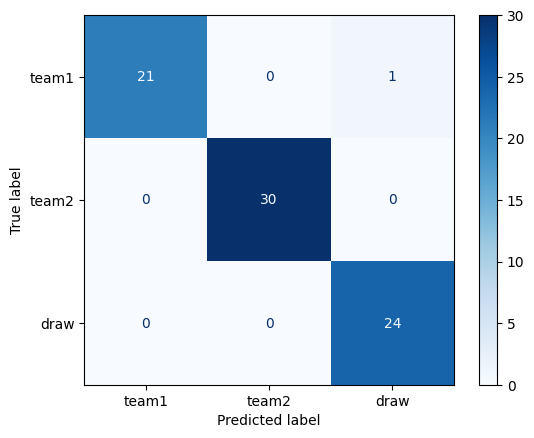

In [16]:
# Confusion Matrix 1 - Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['team1', 'team2', 'draw'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

In [ ]:
# @title Model Training #2 - Random Forest (RF) Classifier

In [17]:
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

print()

importances = pd.Series(rf_clf.feature_importances_, index = X.columns).sort_values(ascending = False)
print("Top 10 Feature Importances:\n", importances.head(10))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        22
           1       0.85      0.97      0.91        30
           2       0.94      0.62      0.75        24

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.86        76
weighted avg       0.88      0.87      0.86        76


Top 10 Feature Importances:
 team2_score                 0.182628
team1_score                 0.163824
team2_Pass                  0.052472
team1_Save attempt          0.050913
team1_Pass                  0.048739
team1_Shot                  0.036832
team2_Shot                  0.035635
team1_Duel                  0.034421
team2_Others on the ball    0.033268
team2_Duel                  0.030777
dtype: float64


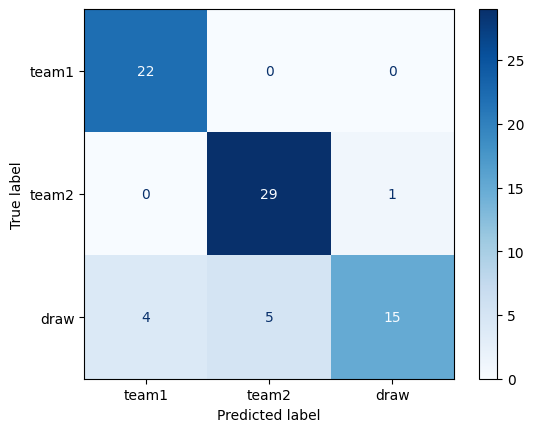

In [18]:
# Confusion Matrix 2 - Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['team1', 'team2', 'draw'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

In [ ]:
# @title Model Training #3 - K-Nearest Neighbors (KNN)

In [19]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.77      0.65        22
           1       0.61      0.83      0.70        30
           2       0.40      0.08      0.14        24

    accuracy                           0.58        76
   macro avg       0.53      0.56      0.50        76
weighted avg       0.53      0.58      0.51        76



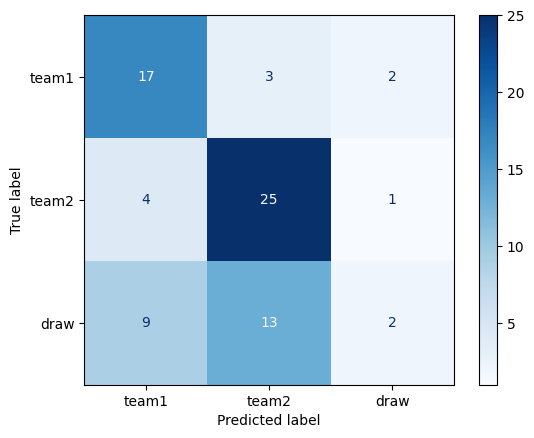

In [20]:
# Confusion Matrix 3 - KNN
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['team1', 'team2', 'draw'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

In [ ]:
# @title Average Accuracy For Each Method After 10 Runs


In [21]:
# Repeat 80/20 proportion train-test split 10 times
accuracies = {'LogisticRegression': [], 'RandomForest': [], 'KNN': []}

team_prediction_tracker = defaultdict(lambda: {'correct': 0, 'total': 0})

for i in range(10):
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_scaled, y, X.index, test_size = 0.2, random_state = 42 + i, stratify = y
    )

    # Logistic Regression (Model 1)
    clf_lr = LogisticRegression(max_iter = 1000)
    clf_lr.fit(X_train, y_train)
    y_pred_lr = clf_lr.predict(X_test)
    accuracies['LogisticRegression'].append(accuracy_score(y_test, y_pred_lr))

    # Random Forest (Model 2)
    clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracies['RandomForest'].append(accuracy_score(y_test, y_pred_rf))

    # KNN (Model 3)
    clf_knn = KNeighborsClassifier(n_neighbors = 5)
    clf_knn.fit(X_train, y_train)
    y_pred_knn = clf_knn.predict(X_test)
    accuracies['KNN'].append(accuracy_score(y_test, y_pred_knn))

    # Track per-team accuracy using Random Forest
    for idx, pred, actual in zip(idx_test, y_pred_rf, y_test):
        row = merged_df.loc[idx]
        actual_team = row['team1_name'] if actual == 0 else row['team2_name'] if actual == 1 else 'Draw'
        predicted_team = row['team1_name'] if pred == 0 else row['team2_name'] if pred == 1 else 'Draw'

        if actual_team == predicted_team:
            team_prediction_tracker[actual_team]['correct'] = team_prediction_tracker[actual_team]['correct'] + 1
        team_prediction_tracker[actual_team]['total'] = team_prediction_tracker[actual_team]['total'] + 1

# Each Model's Average Accuracy
print("Average Accuracies Over 10 Iterations/Runs:")
print()
for model_name, acc_list in accuracies.items():
    print(f"{model_name}: {np.mean(acc_list):.4f}")
    print()

Average Accuracies Over 10 Iterations/Runs:

LogisticRegression: 0.9776

RandomForest: 0.8368

KNN: 0.6211



In [ ]:
# @title Which Teams Are Better Predicted Than Others?


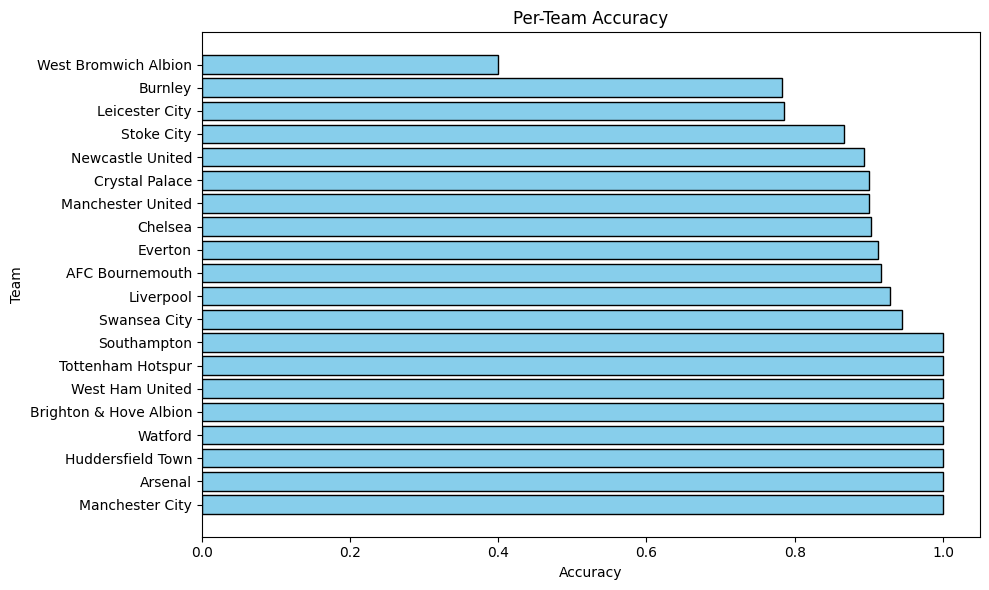

In [22]:
# Compute Per-Team Accuracy
team_accuracies = {}
for team, stats in team_prediction_tracker.items():
    if team == "Draw":
        continue
    accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
    team_accuracies[team] = accuracy

sorted_teams = sorted(team_accuracies.items(), key = lambda x: x[1], reverse = True)
teams, scores = zip(*sorted_teams)

plt.figure(figsize = (10, 6))
plt.barh(teams, scores, color = "skyblue", edgecolor = 'black')
plt.xlabel('Accuracy')
plt.ylabel('Team')
plt.title('Per-Team Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# @title Some Real Examples/Predictions

In [25]:
# Store corresponding indices for original rows
X_train_indices, X_test_indices = train_test_split(X.index, test_size = 0.2, random_state = 42)

# Sample 3 indices from the test set
sample_indices = np.random.choice(X_test_indices, size = 3, replace = False)

for i in sample_indices:
    row = merged_df.loc[i]
    input_data = X.loc[i].values.reshape(1, -1)
    prediction = rf_clf.predict(input_data)[0]
    actual = y.loc[i]

    team1 = row['team1_name']
    team2 = row['team2_name']
    date = row['date']

    prediction_label = team1 if prediction == 0 else team2 if prediction == 1 else 'Draw'
    actual_label = team1 if actual == 0 else team2 if actual == 1 else 'Draw'

    print(f"Match: {team1} vs {team2} on {date}")
    print()
    print(f"Model Prediction: {prediction_label}")
    print(f"Actual Result: {actual_label}")
    print()
    print("First-Half Statistics of Important Features:")
    print(f"{team1} - Shots: {row['team1_Shot']}, Fouls: {row['team1_Foul']}, Passes: {row['team1_Pass']}")
    print(f"{team2} - Shots: {row['team2_Shot']}, Fouls: {row['team2_Foul']}, Passes: {row['team2_Pass']}")
    print("-" * 87)

Match: Watford vs West Ham United on February 10, 2018 at 4:00:00 PM GMT+1

Model Prediction: West Ham United
Actual Result: West Ham United

First-Half Statistics of Important Features:
Watford - Shots: 3, Fouls: 6, Passes: 182
West Ham United - Shots: 5, Fouls: 7, Passes: 147
---------------------------------------------------------------------------------------
Match: West Bromwich Albion vs Southampton on October 21, 2017 at 6:30:00 PM GMT+2

Model Prediction: Southampton
Actual Result: Southampton

First-Half Statistics of Important Features:
West Bromwich Albion - Shots: 2, Fouls: 2, Passes: 120
Southampton - Shots: 8, Fouls: 6, Passes: 270
---------------------------------------------------------------------------------------
Match: West Ham United vs Chelsea on April 8, 2018 at 5:30:00 PM GMT+2

Model Prediction: Chelsea
Actual Result: Draw

First-Half Statistics of Important Features:
West Ham United - Shots: 1, Fouls: 4, Passes: 178
Chelsea - Shots: 9, Fouls: 5, Passes: 314
-